###  Анализ оценок асессоров

**Задача:** определить асессоров, которые хуже справились с заданием.

#### Описание данных:
 1. login — логин асессора
 2. uid — id асессора
 3. docid – id оцениваемого документа
 4. jud — оценка асессора
 5. cjud — правильная оценка

#### План работы и результаты:
1. Проверка на дубликаты. 
2. Сравнение оценки асессора и корректной оценки - возвращаем `True` или `False` в столбце `check`.
3. Группируем данные по id асессора для расчета общего количества оценок, корректных или некорректных оценок - вычисляем процент корректных или некорректных оценок для каждого асессора.
4. 1 документ оценивается 5 асессорами.
5. Формируем список 10 неэффективных асессоров с самым большим процентов неправильных оценок. Среди данного списка 5 асессоров с долей неправильных оценок около 50%, остальные - от 24 до 30%.
6. В топ-10 попали асессоры с 10% неправильных оценок. 

#### Основной показатель - процент корректных оценок

#### Возможные подходы:
1. Оценивать асессоров в зависимости от общего количества оценок, предварительно обозначив категории. Для каждой категории выбирать топ-10. Примеры категорий (на основе данной выборки): 
    * новички (примерно до 370 оценок);
    * эксперт (примерно до 450 оценок);
    * знаток (свыше 451 оценки).
2. Гипотеза - количество оцененных документов влияет на качество оценок, как в лучшую сторону (более опытный асессор дает меньше некорректных оценок), так и в худшую (чем больше оцененных работ, тем больше усталость). На примере данной выборки нет явной зависимости количества оценок и качества оценок.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import datetime

In [2]:
evaluation = pd.read_csv('data_task3.csv', sep = '\t')
evaluation.sort_values(by='docid')

login  uid  docid  jud  cjud
0       assessor158  158      0    0     0
1       assessor238  238      0    0     0
2       assessor488  488      0    0     0
3       assessor136  136      0    0     0
4       assessor300  300      0    0     0
...             ...  ...    ...  ...   ...
249998  assessor160  160  49999    1     1
249995  assessor208  208  49999    1     1
249996  assessor139  139  49999    1     1
249997  assessor333  333  49999    1     1
249999  assessor175  175  49999    1     1

[250000 rows x 5 columns]

In [3]:
evaluation.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 250000 entries, 0 to 249999
Data columns (total 5 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   login   250000 non-null  object
 1   uid     250000 non-null  int64 
 2   docid   250000 non-null  int64 
 3   jud     250000 non-null  int64 
 4   cjud    250000 non-null  int64 
dtypes: int64(4), object(1)
memory usage: 9.5+ MB


In [4]:
evaluation.duplicated().sum()

1

In [5]:
# Проверка совпадения корректной оценки и оценки асессора

evaluation['check'] = (evaluation['jud'] == evaluation['cjud']).astype('str')
evaluation.sample(10)

login  uid  docid  jud  cjud  check
194449  assessor156  156  38889    0     0   True
202745  assessor527  527  40549    0     0   True
93068   assessor547  547  18613    1     0  False
43748   assessor434  434   8749    1     1   True
170320  assessor562  562  34064    0     0   True
44268   assessor473  473   8853    1     0  False
179000  assessor545  545  35800    0     0   True
235646   assessor98   98  47129    0     0   True
9694    assessor186  186   1938    0     0   True
210884  assessor500  500  42176    0     0   True

In [6]:
# Подготовка данных для последующего анализа

evaluation = evaluation.drop(columns = ['login'])
evaluation = pd.get_dummies(evaluation)
evaluation.sample(10)

uid  docid  jud  cjud  check_False  check_True
199474  134  39894    0     0            0           1
90185   117  18037    0     0            0           1
3587    355    717    1     0            1           0
23184   148   4636    1     0            1           0
104677  222  20935    0     0            0           1
118891  308  23778    0     0            0           1
41657   241   8331    0     0            0           1
245099  599  49019    0     0            0           1
187439  152  37487    0     0            0           1
76453   468  15290    0     0            0           1

In [7]:
# Группировка по количеству оценок

evaluation_group = (evaluation.groupby('uid').agg({'jud':'count','check_False':'sum', 'check_True':'sum'})
                .sort_values(by = 'jud'))
                
evaluation_group.rename(columns={'jud':'total_task'}, inplace=True)
evaluation_group

total_task  check_False  check_True
uid                                     
234          99           51        48.0
550         128           35        93.0
255         364           42       322.0
202         365           37       328.0
420         365           36       329.0
..          ...          ...         ...
368         467           48       419.0
165         467           87       380.0
161         480           48       432.0
140         481          108       373.0
191         484           38       446.0

[600 rows x 3 columns]

In [8]:
evaluation_group['incorrect_%'] = (evaluation_group['check_False']/evaluation_group['total_task'])*100
evaluation_group['correct_%'] = (evaluation_group['check_True']/evaluation_group['total_task'])*100
evaluation_group

total_task  check_False  check_True  incorrect_%  correct_%
uid                                                             
234          99           51        48.0    51.515152  48.484848
550         128           35        93.0    27.343750  72.656250
255         364           42       322.0    11.538462  88.461538
202         365           37       328.0    10.136986  89.863014
420         365           36       329.0     9.863014  90.136986
..          ...          ...         ...          ...        ...
368         467           48       419.0    10.278373  89.721627
165         467           87       380.0    18.629550  81.370450
161         480           48       432.0    10.000000  90.000000
140         481          108       373.0    22.453222  77.546778
191         484           38       446.0     7.851240  92.148760

[600 rows x 5 columns]

In [9]:
evaluation_group.describe()

total_task  check_False  check_True  incorrect_%   correct_%
count  600.000000   600.000000  600.000000   600.000000  600.000000
mean   416.666667    66.130000  350.536667    15.934180   84.065820
std     27.024793    22.320097   32.683518     5.546233    5.546233
min     99.000000    31.000000   48.000000     7.619048   42.579075
25%    403.000000    47.000000  334.000000    11.250000   80.853760
50%    417.000000    69.500000  351.000000    16.666667   83.333333
75%    432.250000    80.000000  371.000000    19.146240   88.750000
max    484.000000   236.000000  446.000000    57.420925   92.380952

In [10]:
bottom_10 = evaluation_group.sort_values(by ='incorrect_%', ascending = False).head(10)
bottom_10

total_task  check_False  check_True  incorrect_%  correct_%
uid                                                             
56          411          236       175.0    57.420925  42.579075
3           426          230       196.0    53.990610  46.009390
118         391          205       186.0    52.429668  47.570332
390         412          214       198.0    51.941748  48.058252
234          99           51        48.0    51.515152  48.484848
550         128           35        93.0    27.343750  72.656250
9           423          110       313.0    26.004728  73.995272
335         419          108       311.0    25.775656  74.224344
154         405           99       306.0    24.444444  75.555556
71          433          105       328.0    24.249423  75.750577

In [11]:
top_10 = (evaluation_group.sort_values(by ='correct_%', ascending = False)
          .head(10))
top_10

total_task  check_False  check_True  incorrect_%  correct_%
uid                                                             
296         420           32       388.0     7.619048  92.380952
545         444           34       410.0     7.657658  92.342342
184         402           31       371.0     7.711443  92.288557
63          409           32       377.0     7.823961  92.176039
191         484           38       446.0     7.851240  92.148760
329         420           33       387.0     7.857143  92.142857
450         399           32       367.0     8.020050  91.979950
38          411           33       378.0     8.029197  91.970803
151         420           34       386.0     8.095238  91.904762
528         395           32       363.0     8.101266  91.898734

**Гипотеза.** Процент корректных оценок увеличивается с количеством оцененных документов. На данной выборке гипотеза не подтвердилась, нет явной зависимости от "опыта" и процента корректности оценок.

(350, 500)

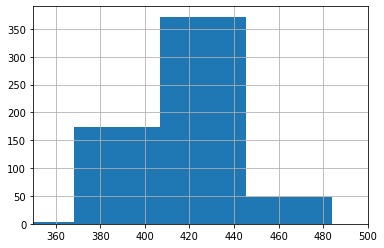

In [12]:
# Диаграмма распределения общего числа оценок

evaluation_group['total_task'].hist()
plt.xlim(350,500)

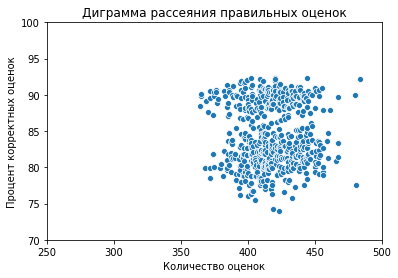

In [13]:
# Зависимость общего числа оценок и корректных оценок

sns.scatterplot(x = evaluation_group['total_task'], y = evaluation_group['correct_%'])
plt.xlim(250,500)
plt.ylim(70,100)
plt.title('Диграмма рассеяния правильных оценок')
plt.xlabel('Количество оценок')
plt.ylabel('Процент корректных оценок')
plt.show()

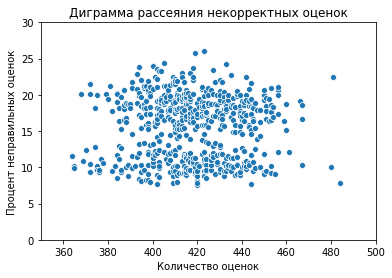

In [14]:
# Зависимость общего числа оценок и некорректных оценок

sns.scatterplot(x = evaluation_group['total_task'], y = evaluation_group['incorrect_%'])
plt.xlim(350,500)
plt.ylim(0,30)
plt.title('Диграмма рассеяния некорректных оценок')
plt.xlabel('Количество оценок')
plt.ylabel('Процент неправильных оценок')
plt.show()